#### In this notebook, causal inference has been performed using all the data

# Importing the necessary packages

In [104]:
import pandas as pd
import causalnex
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from causalnex.structure.notears import from_pandas_lasso
from causalnex.plots import plot_structure,NODE_STYLE,EDGE_STYLE
from causalnex.discretiser import Discretiser
from causalnex.network import BayesianNetwork
from causalnex.network import BayesianNetwork
from causalnex.evaluation import classification_report,roc_auc
from causalnex.inference import InferenceEngine

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,accuracy_score,f1_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

# Instantiating the model

In [1]:
sm = StructureModel()

##### Specify the relationship between features. For example, assuming the following causal relationships are known:

            radius_mean->perimeter_mean
            radius_mean->area_mean
Add these relationships to the structure model

In [2]:
sm.add_edges_from([
                   ('radius_mean','perimeter_mean'),
                   ('radius_mean','area_mean')
                   ])

### Visualizing the structure

In [3]:
sm.edges

OutEdgeView([('radius_mean', 'perimeter_mean'), ('radius_mean', 'area_mean')])

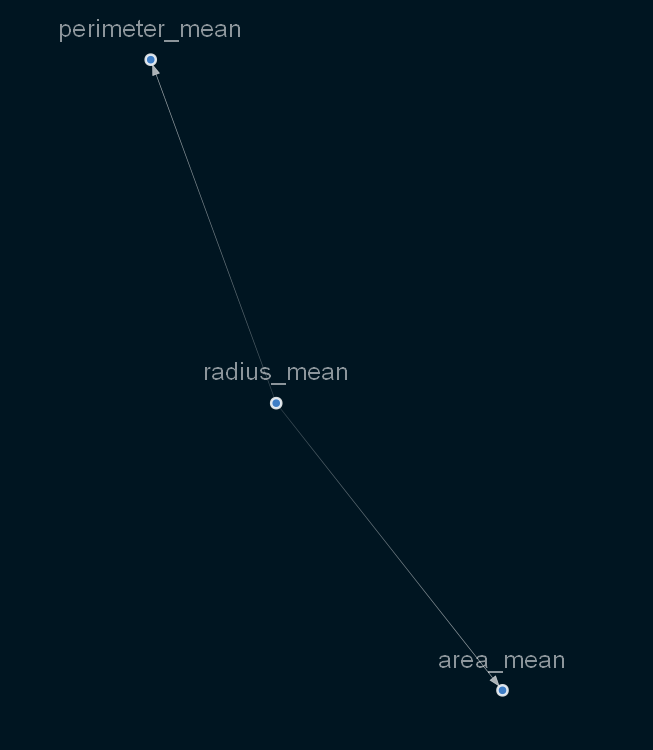

In [4]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

#### Apply the NOTEARS Algorithm to learn the structure

In [5]:
import pandas as pd

df=pd.read_csv('BreastCancer_processed.csv')
df.head()

,Unnamed: 0,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,6,1,18.25,19.98,119.6,1040.0,0.09463,0.10900,0.11270,0.07400,...,22.88,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368
1,7,1,13.71,20.83,90.2,577.9,0.11890,0.16450,0.09366,0.05985,...,17.06,28.14,110.6,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510
2,10,1,16.02,23.24,102.7,797.8,0.08206,0.06669,0.03299,0.03323,...,19.19,33.88,123.8,1150.0,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452
3,11,1,15.78,17.89,103.6,781.0,0.09710,0.12920,0.09954,0.06606,...,20.42,27.28,136.5,1299.0,0.1396,0.5609,0.3965,0.18100,0.3792,0.10480
4,13,1,15.85,23.95,103.7,782.7,0.08401,0.10020,0.09938,0.05364,...,16.84,27.66,112.0,876.5,0.1131,0.1924,0.2322,0.11190,0.2809,0.06287


In [6]:
df=df.drop(columns='Unnamed: 0')
df = df.rename(columns={'concave points_se': 'concave_points_se', 'concave points_worst': 'concave_points_worst','concave points_mean': 'concave_points_mean'})
#selecting the mean columns
mean_df=df.iloc[:, : 5]
mean_df.head()


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean
0,1,18.25,19.98,119.6,1040.0
1,1,13.71,20.83,90.2,577.9
2,1,16.02,23.24,102.7,797.8
3,1,15.78,17.89,103.6,781.0
4,1,15.85,23.95,103.7,782.7


In [7]:
# Apply the NOTEARS algorithm to learn the structure.
from causalnex.structure.notears import from_pandas
sm = from_pandas(df)

### Edge Pruning
Apply thresholding to the weaker edges of the graph. Thresholding can be applied either by specifying the value for the parameter w_threshold in from_pandas, or we can remove the edges by calling the structure model function, remove_edges_below_threshold.

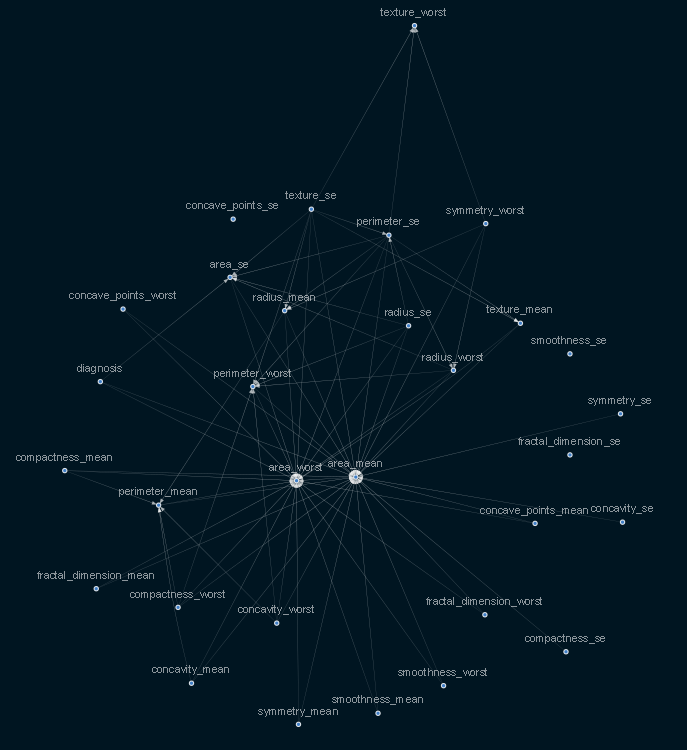

In [8]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2.5",'size':'2.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

#### Relationships that can be inferred from this graph

##### 1.Radius Features-mean of distances from center to points on the perimeter
i.) radius_mean affects the area_mean and the perimeter mean.

ii.)radius_se->perimeter_se,area_se,perimeter_worst,area_mean

iii.)radius_worst->area_se,area_worst,perimeter_worst

Radius features means affect the area and perimeter features.This makes sense because the radius is used in calculation of the area and the perimeter


##### 2. Perimeter Features
i.) perimeter_mean-->area_worst,area_mean

ii.)perimeter_se has no effect on any of the features

iii.)perimeter_worst-->texture_mean,radius_worst


##### 3. Area Features
i.)area_mean

ii.)area_se affects the area_worst,area_mean

iii.)area_worst


##### 4.Texture Features
i.)texture_mean affects area_mean anad area_worst

ii.)texture_se affects perimeter_mean,texture_mean,texture_worst,radius_mean, area_se

iii.)texture_worst has no effect on any feature


##### 5. Smoothness Feaures-local variation in radius lengths
i.)smoothness_mean affects the area_mean,area_worst

ii.)smoothness_se has no effect on any feature

iii.)smoothness_worst affects the area_mean, area_worst


##### 6. Compactness Features-perimeter^2 / area - 1.0
i.)compactness_mean affects the perimeter_mean,area_worst,area_mean

ii.)compactness_se affects the area_mean

iii.)compactness_worst affects the perimeter_mean,perimeter_worst,area_worst,area_mean


##### 7. Concavity Features-severity of concave portions of the contour
i.)concavity_mean affects the perimeter_mean,area_worst,area_mean

ii.)concavity_se affects area_mean

iii.)concavity_worst affects area_mean,area_worst,perimeter_mean,perimeter_worst


##### 8.Concave Points Features-number of concave portions of the contour
i.)concavity points_mean affects area_mean,area_worst

ii.)concavity points_se has no effect on any of the features 

iii.)concavity points_worst affects area_mean,area_worst


##### 9.Symmetry Features
i.)symmetry_mean affects area_mean,area_worst

ii.)symmetry_se affects area_mean

iii.)symmetry_worst affects area_mean,radius_mean,radius_worst


##### 10.Fractal dimension Features
i.)fractal_dimension_mean affects area_mean,area_worst

ii.)fractal_dimension_se has no effect on any of the features 

iii.)fractal_dimension_worst affects area_mean,area_worst
   
   
##### Diagnosis
Diagnosis seems to affect area_mean,area_se and area_worst. This does not make sense since the diagnosis is the outcome hence this is what is being predicted

#### Correcting the erroneus edges
To correct erroneous relationships, we can incorporate domain knowledge into the model after structure learning. We can modify the structure model through adding and deleting the edges. For example, we can add and remove edges as:

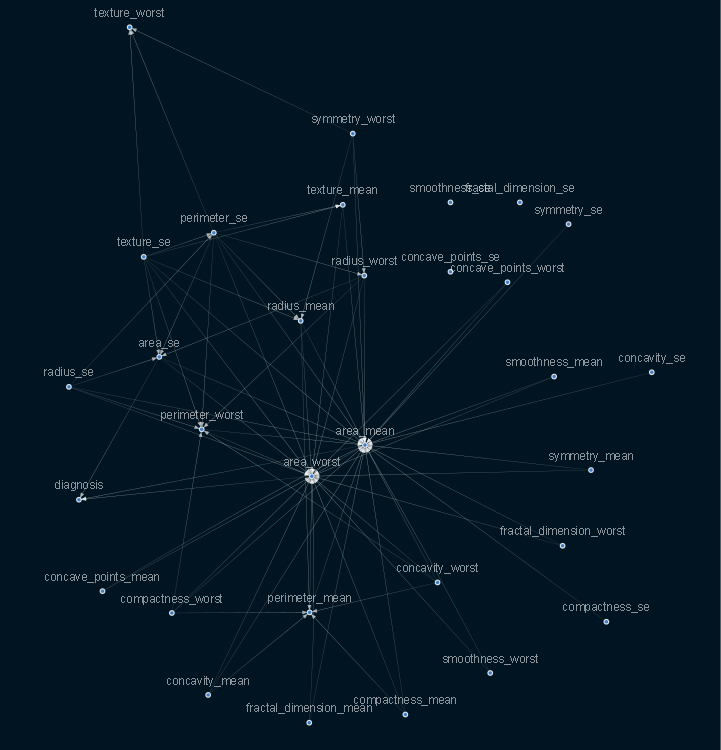

In [45]:
#sm.add_edge()
#sm.remove_edge()

viz = plot_structure(
    sm,
    graph_attributes={"scale": "2.5",'size':'2.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

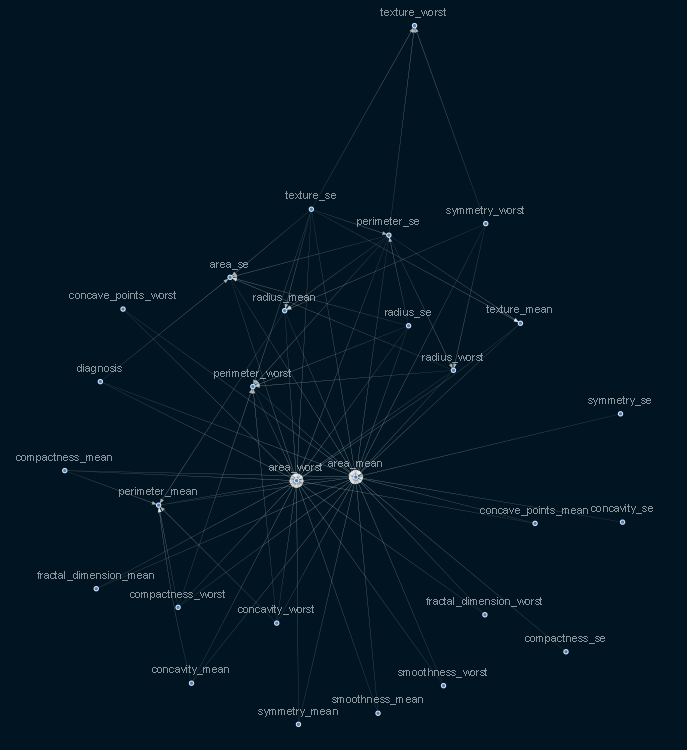

In [15]:
sm_large = sm.get_largest_subgraph()

viz = plot_structure(
    sm_large,
    graph_attributes={"scale": "2.5", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

### Discretising the features
For our data the fixed method will be applied, providing static values that define the bucket boundaries. All the columns will be discretised into uniform (specify the number of buckets and discretizer will create uniformly spaced buckets). Each bucket will be labelled as an integer from zero.


In [87]:
discretised_data=df.copy()
for column in discretised_data.columns:
    discretised_data[column] = Discretiser(method="uniform",num_buckets=10,
                          numeric_split_points=[1, 10]).transform(discretised_data[column].values)
discretised_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1,2,2,2,2,0,0,0,0,0,...,2,2,2,2,0,0,0,0,0,0
1,1,2,2,2,2,0,0,0,0,0,...,2,2,2,2,0,0,0,0,0,0
2,1,2,2,2,2,0,0,0,0,0,...,2,2,2,2,0,0,0,0,0,0
3,1,2,2,2,2,0,0,0,0,0,...,2,2,2,2,0,0,0,0,0,0
4,1,2,2,2,2,0,0,0,0,0,...,2,2,2,2,0,0,0,0,0,0


In [18]:
for column in discretised_data.columns:
    unique_values=discretised_data[column].unique()
    print(column,unique_values)

diagnosis [1 0]
radius_mean [2 1]
texture_mean [2 1]
perimeter_mean [2]
area_mean [2]
smoothness_mean [0]
compactness_mean [0]
concavity_mean [0]
concave_points_mean [0]
symmetry_mean [0]
fractal_dimension_mean [0]
radius_se [0]
texture_se [0 1]
perimeter_se [1 0]
area_se [2 1]
smoothness_se [0]
compactness_se [0]
concavity_se [0]
concave_points_se [0]
symmetry_se [0]
fractal_dimension_se [0]
radius_worst [2 1]
texture_worst [2]
perimeter_worst [2]
area_worst [2]
smoothness_worst [0]
compactness_worst [0]
concavity_worst [0]
concave_points_worst [0]
symmetry_worst [0]
fractal_dimension_worst [0]


# Instantiate a Bayesian Network

In [92]:
bn = BayesianNetwork(sm_large)

In [93]:
# Create labels for the the diagnosis column
diagnosis_map = {0: "Benign", 1: "Malignant"}
discretised_data["diagnosis"] = discretised_data["diagnosis"].map(diagnosis_map)

discretised_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,Malignant,2,2,2,2,0,0,0,0,0,...,2,2,2,2,0,0,0,0,0,0
1,Malignant,2,2,2,2,0,0,0,0,0,...,2,2,2,2,0,0,0,0,0,0
2,Malignant,2,2,2,2,0,0,0,0,0,...,2,2,2,2,0,0,0,0,0,0
3,Malignant,2,2,2,2,0,0,0,0,0,...,2,2,2,2,0,0,0,0,0,0
4,Malignant,2,2,2,2,0,0,0,0,0,...,2,2,2,2,0,0,0,0,0,0


In [94]:
# Create labels for the other features column
discretised_data_new=discretised_data.copy()
discretised_data_new=discretised_data_new.iloc[:, 1:]
discretised_data_new.head()
for column in discretised_data_new.columns:
    features_map={0: "Low", 1: "Medium",2:"High"}
    discretised_data_new[column] = discretised_data_new[column].map(features_map)

diagnosis=discretised_data['diagnosis']
discretised_data_new= discretised_data_new.join(diagnosis)
discretised_data_new.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,High,High,High,High,Low,Low,Low,Low,Low,Low,...,High,High,High,Low,Low,Low,Low,Low,Low,Malignant
1,High,High,High,High,Low,Low,Low,Low,Low,Low,...,High,High,High,Low,Low,Low,Low,Low,Low,Malignant
2,High,High,High,High,Low,Low,Low,Low,Low,Low,...,High,High,High,Low,Low,Low,Low,Low,Low,Malignant
3,High,High,High,High,Low,Low,Low,Low,Low,Low,...,High,High,High,Low,Low,Low,Low,Low,Low,Malignant
4,High,High,High,High,Low,Low,Low,Low,Low,Low,...,High,High,High,Low,Low,Low,Low,Low,Low,Malignant


In [95]:
# Split 90% train and 10% test
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

### Model Probability

Fit the probability distrbution of the Bayesian Network

Specify all of the states that each node can take

In [96]:
bn = bn.fit_node_states(discretised_data)

## Fit Conditional Probability Distributions

Use the dataset to learn the conditional probablilty distributions (CPDs) of each node,along with a method of how to do this fit.

In [97]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")


In [98]:
#inspect the conditional probability distributions of the target variable
bn.cpds["diagnosis"]

,
diagnosis,
Benign,0.752778
Malignant,0.247222


In [99]:
predictions = bn.predict(discretised_data, "diagnosis")

In [100]:
classification_report(bn, test, "diagnosis")

{'diagnosis_Benign': {'precision': 0.75,
  'recall': 1.0,
  'f1-score': 0.8571428571428571,
  'support': 30},
 'diagnosis_Malignant': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 10},
 'accuracy': 0.75,
 'macro avg': {'precision': 0.375,
  'recall': 0.5,
  'f1-score': 0.42857142857142855,
  'support': 40},
 'weighted avg': {'precision': 0.5625,
  'recall': 0.75,
  'f1-score': 0.6428571428571428,
  'support': 40}}

In [68]:
roc, auc = roc_auc(bn, test, "diagnosis")
print(auc)

0.75


# Querying Marginals

After iterating over our model structure, CPDs, and validating our model quality, we can query our model under defferent observation to gain insights.

## Baseline Marginals

To query the model for baseline marginals that reflect the population as a whole, a query method can be used. First let’s update our model using the complete dataset, since the one we currently have was only built from training data.

In [69]:
bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

In [70]:
ie = InferenceEngine(bn)
marginals = ie.query()
marginals["diagnosis"]

{'Begnin': 0.7525000000000002, 'Malignant': 0.24750000000000003}

This output means that the probability that there will be a Begnin tumor is 0.75 and the probability of having a Malignant tumor would be 0.25

#### Carry out a sanity check to confirm if the above is true

In [71]:
labels, counts = np.unique(discretised_data["diagnosis"], return_counts=True)
list(zip(labels, counts))

[('Begnin', 300), ('Malignant', 98)]

The proportion of malignant tumors would be:

    98/(300+98)=0.246
    
This is close to the marginal probability obtained above.

A marginal probability(unconditional probability) is the probability that a certain event occurs.

A conditional probability is the probability that one event occurs given that another one has occurred

## Comparison with machine learning models

Splitting the dataset

In [ ]:
train, test = train_test_split(df.copy(), train_size=0.8, test_size=0.2, random_state=7)

### Using the Logistic Regression

In [79]:
clf = LogisticRegression()
clf.fit(train.drop(columns=['diagnosis']), train['diagnosis'])

pred = clf.predict(test.drop(columns=['diagnosis']))
true = test['diagnosis']

print('Recall: {:.2f}'.format(recall_score(y_true=true, y_pred=pred)))
print('F1: {:.2f} '.format(f1_score(y_true=true, y_pred=pred)))
print('Accuracy: {:.2f} '.format(accuracy_score(y_true=true, y_pred=pred)))
print('Precision: {:.2f} '.format(precision_score(y_true=true, y_pred=pred)))

Recall: 0.88
F1: 0.88 
Accuracy: 0.95 
Precision: 0.88 


### Using Random Forest Classifier

In [82]:
from sklearn.ensemble import RandomForestClassifier

train, test = train_test_split(df.copy(), train_size=0.8, test_size=0.2, random_state=7)

rf = RandomForestClassifier()
rf.fit(train.drop(columns=['diagnosis']), train['diagnosis'])

pred = rf.predict(test.drop(columns=['diagnosis']))
true = test['diagnosis']

print('Recall: {:.2f}'.format(recall_score(y_true=true, y_pred=pred)))
print('F1: {:.2f} '.format(f1_score(y_true=true, y_pred=pred)))
print('Accuracy: {:.2f} '.format(accuracy_score(y_true=true, y_pred=pred)))
print('Precision: {:.2f} '.format(precision_score(y_true=true, y_pred=pred)))

Recall: 1.00
F1: 0.97 
Accuracy: 0.99 
Precision: 0.94 
